# Implement quantum operations using Paddle Quantum's `gate` and `channel`

_Copyright (c) 2023 Institute for Quantum Computing, Baidu Inc. All Rights Reserved._

The `gate` and `channel` modules allow basic quantum operations to be defined. They can act on a state object directly or be inserted into a quantum circuit. Paddle Quantum provides a list of common operations but customized ones can also be created.

In [12]:
import paddle_quantum
from paddle_quantum.ansatz import Circuit
from paddle_quantum.gate.custom import Oracle
from paddle_quantum.channel import *
from paddle_quantum.state.common import zero_state
from paddle_quantum.qinfo import qft_generation, random_channel
from paddle_quantum.linalg import dagger

## Custom gates
Previously, we've seen how to create a gate object and insert it into a circuit. Users can also implement customized unitary operation using the Oracle class.

For example, consider the n qubit inverse quantum Fourier transform (QFT), it's a unitary operation whose matrix is given by

$$
\frac{1}{\sqrt{N}}\begin{pmatrix}
    1 & 1 & 1 & \ldots & 1  \\
    1 & \omega^{N-1} & \omega^{N-2} & \ldots & \omega \\
    1 & \omega^{2(N-1)} & \omega^{2(N-2)} & \ldots & \omega^2 \\
    \ldots & \ldots & \ldots & \ldots & \ldots \\
    1 & \omega^{(N-1)(N-1)} & \omega^{(N-1)(N-2)} & \ldots & \omega^{N-1}
\end{pmatrix}
$$

where $N=2^n$ is the dimension of the Hilbert space and $\omega = e^{2\pi i/N}$.

The following code creates an oracle that implements a 2-qubit inverse QFT.

In [13]:
unitary = qft_generation(2) # obtain matrix for 2-qubit QFT using Paddle Quantum's built-in function
unitary = dagger(unitary) # obtain matrix for inverse QFT by calculating conjugate transpose of QFT matrix using Paddle Quantum's built-in function
QFT_inverse = Oracle(unitary)

As a gate object, we can insert it into a circuit and print the circuit. 

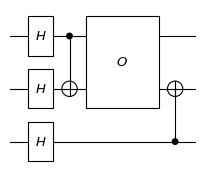

In [14]:
cir = Circuit(3)
cir.h()
cir.cnot([0,1])
cir.append(QFT_inverse) # insert the oracle
cir.cnot([2,1])
cir.plot()

**Note**: to print the oracle, it must not be disconnected, otherwise error message will be displayed.


To change how the oracle is printed, users can modify the content of gate_info. Users can change the name of the oracle printed and the width of the gate in the plot.

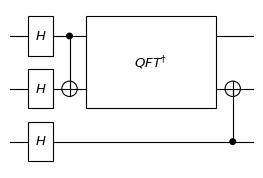

In [15]:
gate_info = {
    'texname': r'$QFT^{\dagger}$', # change the name of the oracle when printing the circuit
    'plot_width': 1.5, # change the width of the box representing the oracle
}
# update gate_info of the oracle
QFT_inverse.gate_info.update(gate_info)
# create the same circuit as before
cir = Circuit(3)
cir.h()
cir.cnot([0,1])
cir.append(QFT_inverse) # insert the oracle gate
cir.cnot([2,1])
cir.plot()

Another way of inserting an oracle into a circuit is by calling `Circuit.oracle` directly when creating the circuit.

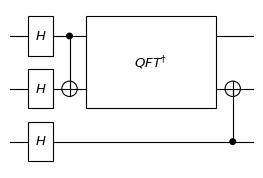

In [16]:
cir=Circuit(3)
cir.h()
cir.cnot([0,1])
# call cir.oracle directly to create an oracle gate, its gate_info can also be specified when creating
cir.oracle(unitary, qubits_idx=[0,1], latex_name=r'$QFT^{\dagger}$', plot_width=1.5) 
cir.cnot([2,1])
cir.plot()

## Channel

Paddle Quantum also supports channel as the most general quantum operation.

There are two ways of creating a channel. Users can either create one of the common channels provided by Paddle Quantum, or create a custom channel.

**Note**: Unlike `gate` object which supports both in `'state_vector'` and `'density_matrix'` backend, `channel` must be used in `'density_matrix'` backend.

In [17]:
paddle_quantum.set_backend('density_matrix') # set the backend to density matrix

For example, we can create a bit flip channel and apply it to the zero state. For the full list of common channels, see [API of Paddle Quantum](https://qml.baidu.com/api/paddle_quantum.channel.common.html)

In [18]:
bit_flip_channel = BitFlip(prob=0.5, num_qubits=1) # define a single qubit bit flip channel with probability 0.5
input = zero_state(1)
output = bit_flip_channel(input) # apply bit flip channel to input zero state
print(output)

[[0.49999997+0.j 0.        +0.j]
 [0.        +0.j 0.49999997+0.j]]


A custom channel can be created using either its Kraus operators, Stinespring isometry, or Choi matrix. We show how to create a custom channel using these three different representations. We generate them randomly using the built-in function from Paddle Quantum.

**Note**: the convention for Choi matrix in PaddleQuantum is that the channel acts on the second system, i.e.

$$
    J(\Lambda) = \sum_{i,j} |i\rangle\langle j| \otimes \Lambda(|i\rangle\langle j|).
$$
where $\Lambda$ denotes the channel.

In [19]:
# generate Kraus operators of a random channel
kraus = random_channel(num_qubits=1, target='Kraus') 
# create channel using Kraus operators
custom_kraus = KrausRepr(kraus)

# generate Stinespring isometry of a random channel
stinespring = random_channel(num_qubits=1, target='Stinespring')
# create channel using Stinespring isometry
custom_stinespring = StinespringRepr(stinespring)

# generate Choi matrix of a random channel
choi = random_channel(num_qubits=1, target='Choi')
# create channel using Choi matrix
custom_choi = ChoiRepr(choi)

Channel can also be inserted into a circuit using the same syntax as for gate. However, currently printing circuit containing a channel is not supported.

In [20]:
 # by default, the channel would act on qubit with index 0, we can specify which qubit it acts on by providing qubits_idx
custom_choi = ChoiRepr(choi, qubits_idx=[2])
cir = Circuit(3)
cir.append(bit_flip_channel) # insert a channel object at the end of the circuit
cir.h()
cir.insert(index=2, operator = custom_choi) # insert a channel object at specific position
cir.bit_flip(0.5, qubits_idx=[2]) # create a channel when building the circuit